# Voxel velocity distribution

To calculate the likelihood of a model, one needs to know the underlying distribution of the modelled parameter. The naive solution is assuming that the distribution of galaxy velocities follows a Gaussian, such that the sum of squares in a voxel follows a $\chi^2$-distribution, which we will evaluate below.

In [1]:
import my_functions as mf
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [2]:
dmo = mf.LoadSimulation('/net/hydra/data2/quinten/data/dmo_fiducial/SOAP-HBT/halo_properties_0077.hdf5')
dmo.selext_galaxies_mass_threshold([10**11, np.inf])
dmo.load_all(128)

Mass range: 11.0 - inf
Galaxies: 7009562


/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:430: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:102: RuntimeWarning: invalid value encountered in divide
  self.voxel_velocity = np.sqrt(voxel_velocity_sum_of_squares / voxel_count)
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:113: RuntimeWarning: invalid value 

The distribution of all RMS voxel velocities is shown below.

In [3]:
v = dmo.voxel_velocity[0][dmo.number_density > 0]
bin_edges = np.linspace(0, np.max(v), 100)


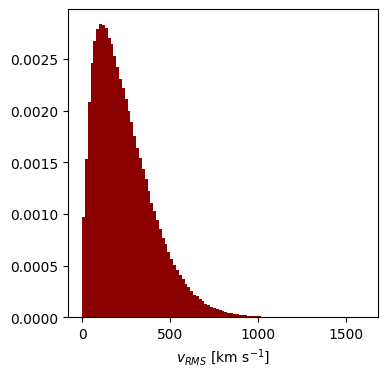

In [4]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(0, np.max(v), 100)

ax.hist(v, bins=bin_edges, color='darkred', density=True)

ax.set(
    xlabel='$v_{RMS}$ [km s$^{-1}$]',
)

plt.show()

The $\chi^2$-distribution is dependent on the number of free parameters, i.e. the number of galaxies in one voxel. To correctly fit a $\chi^2$-distribution to the data, we select only voxels with the same number of galaxies, e.g. $n_g=10$.

In [5]:
from scipy.stats import chi2

In [6]:
# Convert RMS velocity to sum of squares velocity, as this is the what a chi-squared distribution describes
def chi2_pdf(v_rms, dof, loc, scale, height):
    return chi2.pdf(dof*v_rms**2, dof, loc, scale) * height

In [7]:
def chi2_pdf_fixed_dof(dof):
    return lambda v_rms, loc, scale, height, dof=dof: chi2_pdf(v_rms, dof, loc, scale, height)

In [8]:
def prep_fit(v):
    bin_edges = np.linspace(0, np.max(v), 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    xspace = bin_edges[1] - bin_edges[0]
    counts = np.histogram(v, bin_edges)[0]
    pdf_data = counts / np.sum(counts) / xspace
    return bin_centers, pdf_data

In [9]:
n_g = 10
v = dmo.voxel_velocity[0][dmo.number_density == n_g]
bin_centers, pdf_data = prep_fit(v)

In [10]:
fit, _ = curve_fit(chi2_pdf_fixed_dof(n_g), bin_centers, pdf_data, p0=[-100000, 100000, 30000])

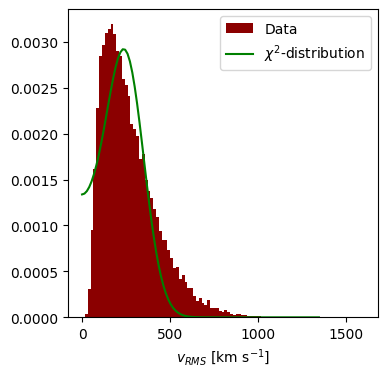

In [11]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(0, np.max(v), 100)

ax.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)
ax.plot(xx, chi2_pdf(xx, n_g, *fit), label=r'$\chi^2$-distribution', color='green')
ax.legend()

ax.set(
    xlabel='$v_{RMS}$ [km s$^{-1}$]',
)

plt.show()

This fit is obviously not great. One reason this may be the case is that a $\chi^2$-distribution describes independent variables. The velocities are not independent, which causes a problem. Another possibility is fitting a $\chi^2$-distribution without fixing the degrees of freedom of the model, which is done below for multiple galaxy number densities.

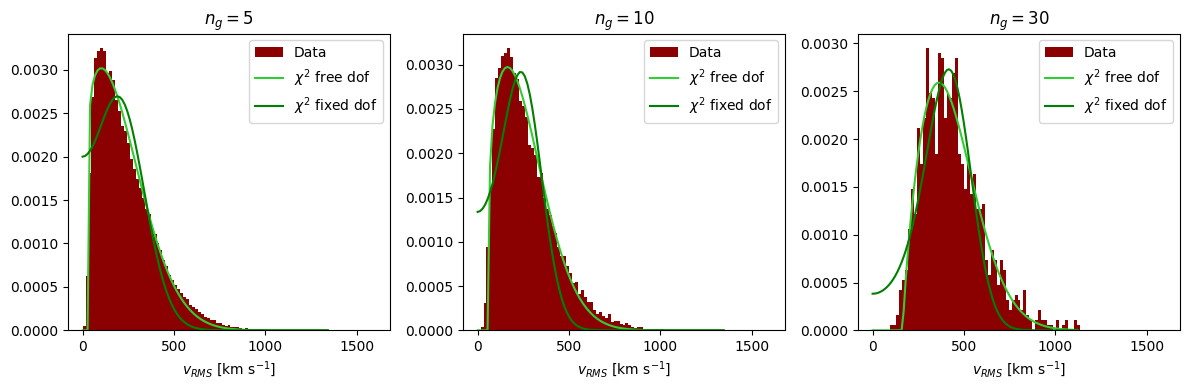

In [12]:
fig, ax = plt.subplots(1,3,figsize=[12,4])

for axis, n_g in zip(ax, [5, 10, 30]):
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_centers, pdf_data = prep_fit(v)
    
    fit_free_dof, _ = curve_fit(chi2_pdf, bin_centers, pdf_data, p0=[n_g-1, 0, 100000, 600])
    fit_fixed_dof, _ = curve_fit(chi2_pdf_fixed_dof(n_g), bin_centers, pdf_data, p0=[0, 100000, 1000])

    xx = np.linspace(0, np.max(v), 100)

    axis.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)
    axis.plot(xx, chi2_pdf(xx, *fit_free_dof), label=r'$\chi^2$ free dof', color='limegreen')
    axis.plot(xx, chi2_pdf(xx, n_g, *fit_fixed_dof), label=r'$\chi^2$ fixed dof', color='green')
    axis.legend()

    axis.set(
        xlabel='$v_{RMS}$ [km s$^{-1}$]',
        title=f'$n_g=${n_g}'
    )

fig.tight_layout()
plt.show()

Keeping the degrees of freedom as a free parameter greatly increases the fits. However, there is not a lot of physical explanation of why this should be allowed. Also, since the fits are still not perfect, we explore another option: the Maxwell-Boltzman distribution and the skew normal distribution.

In [13]:
from scipy.stats import skewnorm

In [14]:
def maxwell_pdf(x, a):
    return np.sqrt(2/np.pi) * x**2/a**3 * np.exp(-x**2/2/a**2)

In [15]:
def maxwell_pdf_scaled(x, a, width, loc):
    return np.sqrt(2/np.pi) * ((x-loc)*width)**2/a**3 * np.exp(-((x-loc)*width)**2/2/a**2)

In [16]:
def skewnorm_pdf(x, a, b, c):
    return skewnorm.pdf(x, a, b, c)# / np.max([(1-skewnorm.cdf(0, a, b, c)), .1])

In [17]:
v = dmo.voxel_velocity[0][dmo.number_density > 0]
bin_centers, pdf_data = prep_fit(v)

In [18]:
p0_a, _ = curve_fit(maxwell_pdf, bin_centers, pdf_data)
fit_mb, _ = curve_fit(maxwell_pdf_scaled, bin_centers, pdf_data, p0=[p0_a[0], 1, 0])
fit_sn, _ = curve_fit(skewnorm_pdf, bin_centers, pdf_data)

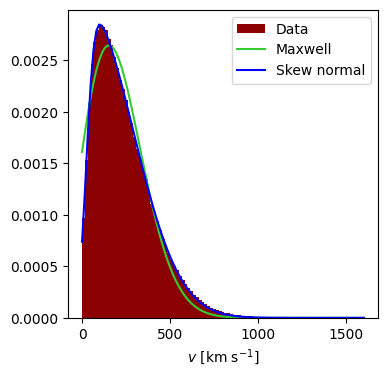

In [19]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(0, np.max(v), 100)

ax.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)
ax.plot(xx, maxwell_pdf_scaled(xx, *fit_mb), label='Maxwell', color='limegreen')
ax.plot(xx, skewnorm_pdf(xx, *fit_sn), label='Skew normal', color='blue')
ax.legend()

ax.set(
    xlabel='$v$ [km s$^{-1}$]',
)

plt.show()

The skewnormal distribution is a very good fit to the whole population of RMS voxel velocities. It is useful to test whether it describes voxel velocities with fixed number densities as well.

In [20]:
def fit_skew_norm(v, n_bins, p0=None):
    bin_edges = np.linspace(0, np.max(v), 100)
    bin_centers, pdf_data = prep_fit(v)
    fit, _ = curve_fit(skewnorm_pdf, bin_centers, pdf_data, p0=p0)
    return bin_edges, fit


In [21]:
def plot_skew_norm(ax, bin_edges, fit):
    ax.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)

    xx = np.linspace(0, np.max(v), 100)
    ax.plot(xx, skewnorm_pdf(xx, *fit), label='Skew normal', color='blue')

/var/tmp/zegveld/ipykernel_4138954/1592178.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, _ = curve_fit(skewnorm_pdf, bin_centers, pdf_data, p0=p0)


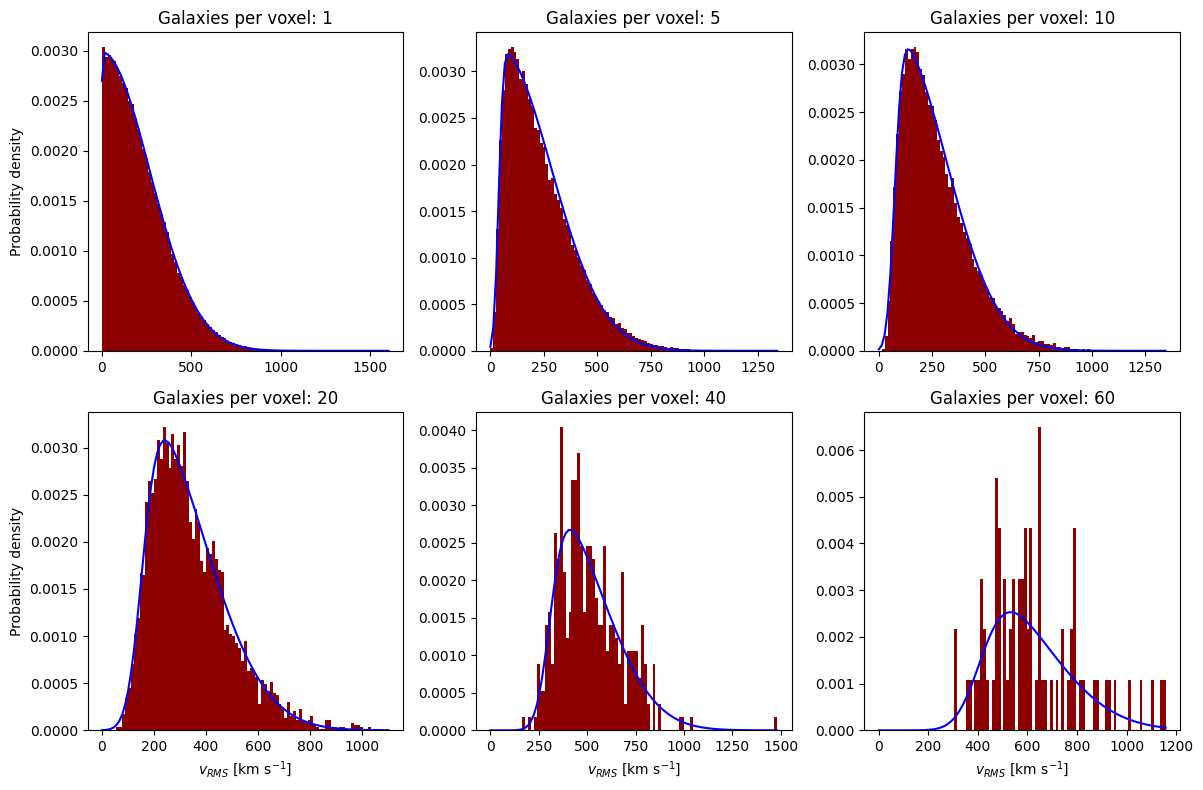

In [22]:
fig, ax = plt.subplots(2, 3,figsize=[12, 8])

_, p0 = fit_skew_norm(dmo.voxel_velocity[0][dmo.number_density > 0], 100)
for n_g, axis in zip([1, 5, 10, 20, 40, 60], ax.flatten()):
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_edges, fit = fit_skew_norm(v, 100, p0)
    plot_skew_norm(axis, bin_edges, fit)
    axis.set_title(f'Galaxies per voxel: {n_g}')

for axis in ax[:, 0]:
    axis.set_ylabel('Probability density')
for axis in ax[1, :]:
    axis.set_xlabel('$v_{RMS}$ [km s$^{-1}$]')


fig.tight_layout()
plt.show()

The skew normal distribution describes the RMS voxel velocities well. From now on, we will use this distribution to estimate model errors.